# Visualize particle tracks on maps

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pickle
from mpl_toolkits.basemap import Basemap

%matplotlib inline

#### Parameters

In [5]:
# colors:
land_color = '#a9a7a2'

# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax - imin
jsize = jmax - jmin

# run result file location:
base_folder = '/ocean/brogalla/GEOTRACES/parcels/Pb-chapter/'

#### Load files

In [9]:
# Load results: 
traj_t1, time_t1, lon_t1, lat_t1, depth_t1, dPb_t1 = load_tracks(f'{base_folder}test2-20230202.nc', tracer='dissolpb')

In [6]:
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = mesh['nav_lon'].values
mesh_lat     = mesh['nav_lat'].values
mesh_bathy   = mesh['tmask'][0,:,:,:].values
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mesh['nav_lev'].values

#### Functions

In [7]:
def load_tracks(filename, tracer='dissolpb'):
    file  = xr.open_dataset(filename)
    traj  = file['trajectory'].values # dimensions: number of particles, tracks
    time  = file['time'].values       # units: seconds
    lat   = file['lat'].values        # degrees North
    lon   = file['lon'].values        # degrees East
    depth = file['z'].values          # meters
    trace = file[tracer].values       # tracer concentration
    
    return traj, time, lon, lat, depth, trace

In [68]:
def plot_map_tracks(lont, latt, trajt, tracer, vmin=0, vmax=10):
    fig, ax1, ax2, proj1, proj2 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Pb-tracks2.pickle','rb'))

    x1, y1 = proj1(lont, latt)
    x2, y2 = proj2(lont, latt)

    x_ANHA12, y_ANHA12 = proj2(mesh_lon, mesh_lat)
    mdomain = np.zeros(mesh_lon.shape)
    mdomain[imin:imax, jmin:jmax] = 1
    mask_domain = np.ma.masked_where((mdomain > 0.1), mesh_lon)
    
    proj2.contourf(x_ANHA12, y_ANHA12, mask_domain, colors=['#d4d4d3'], zorder=1) # land mask
    proj2.contourf(x_ANHA12, y_ANHA12, bathy_masked[0,:,:], colors=['#d4d4d3'], zorder=1) # land mask
    
    # plot tracks
    for particle in range(0,trajt.shape[0]):
        x_plot1 = x1[particle,:][x1[particle,:] < 1e10]
        y_plot1 = y1[particle,:][y1[particle,:] < 1e10]
        
        x_plot2 = x2[particle,:][x2[particle,:] < 1e10]
        y_plot2 = y2[particle,:][y2[particle,:] < 1e10]

        ax1.scatter(x_plot1, y_plot1, s=0.7, c=tracer[particle,:][y1[particle,:] < 1e10], zorder=4, vmin=vmin, vmax=vmax)
        ax2.scatter(x_plot2, y_plot2, s=0.7, c=tracer[particle,:][y2[particle,:] < 1e10], zorder=4, vmin=vmin, vmax=vmax)


    # mark start locations
    ax1.scatter(x1[:,0], y1[:,0], s=8, c=tracer[:,0], edgecolor='w', linewidth=0.5, zorder=4)
    ax2.scatter(x2[:,0], y2[:,0], s=8, c=tracer[:,0], edgecolor='w', linewidth=0.5, zorder=4)
        
    # fig.colorbar(c, shrink=0.5, label='Time [hours]')
    return

#### Main section

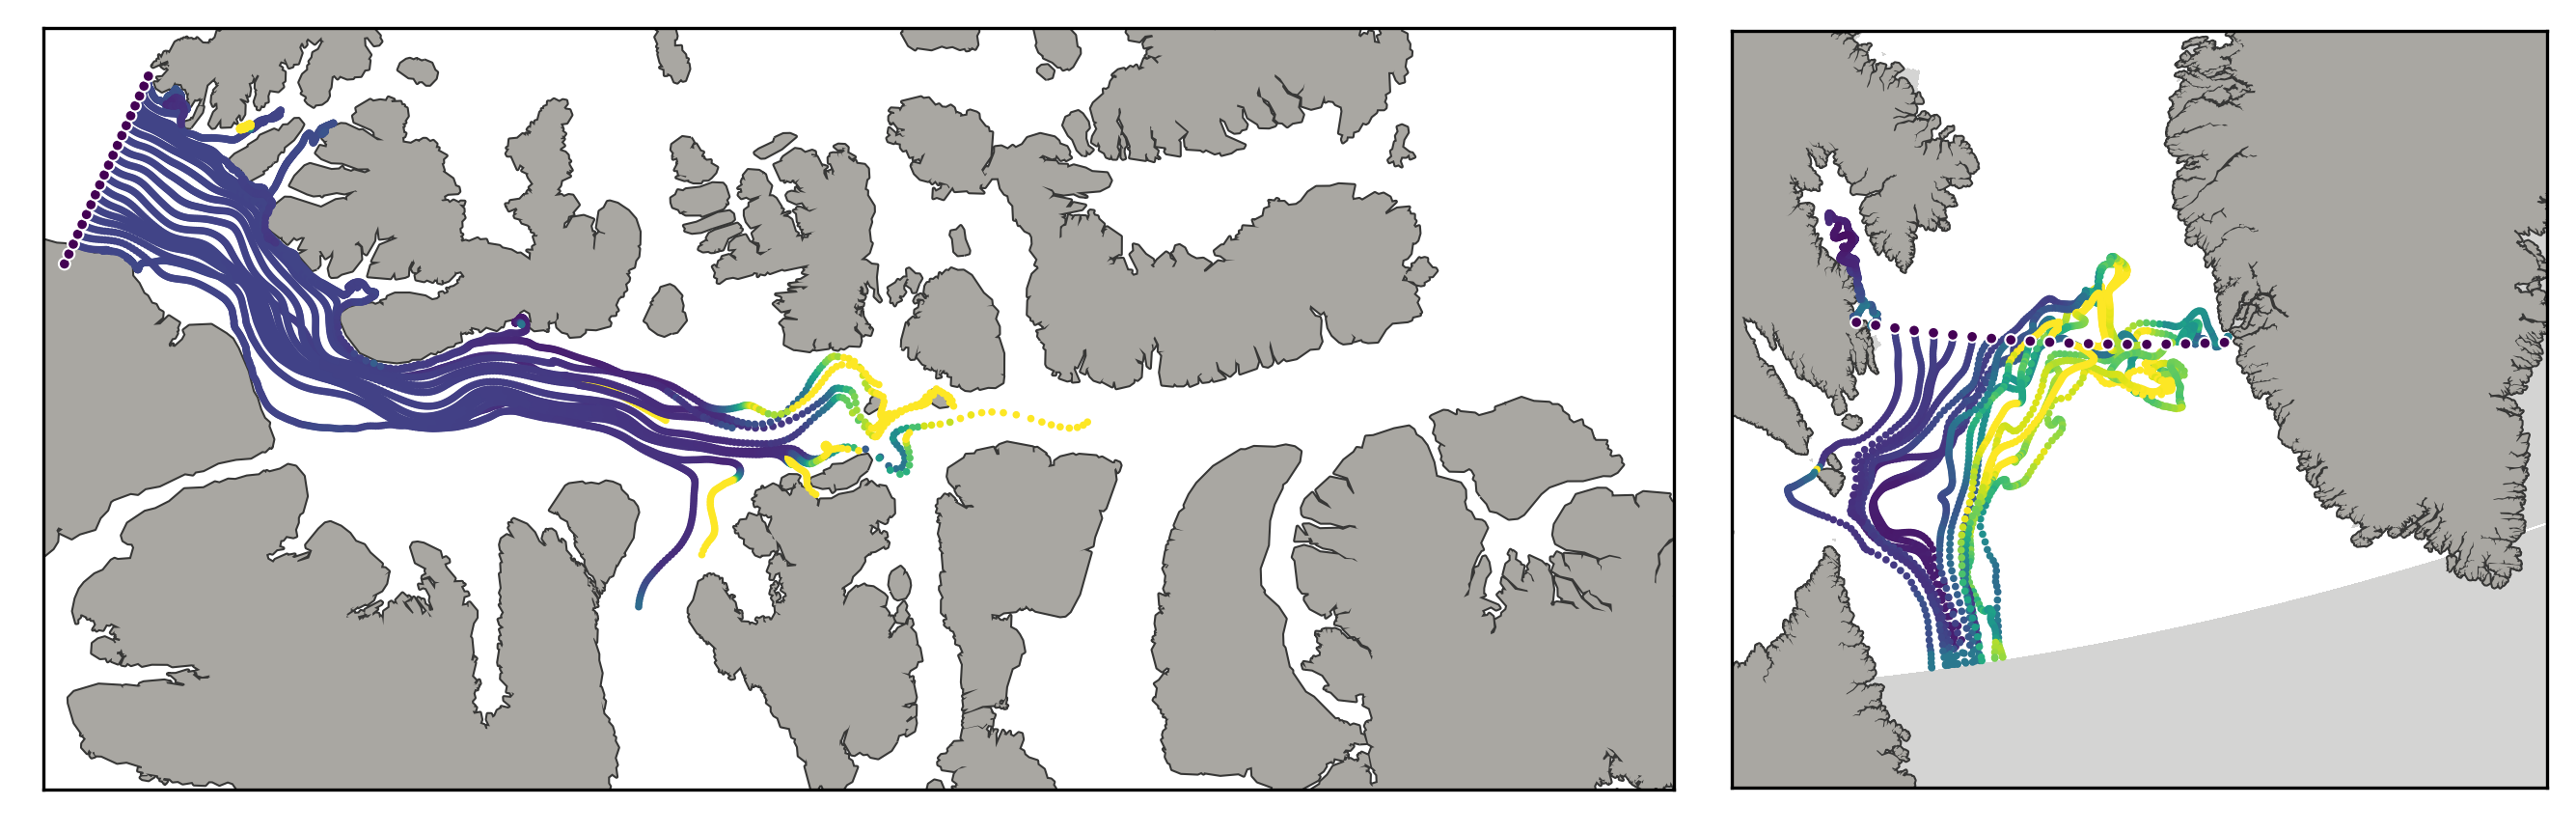

In [69]:
start_depth = depths[0]
plot_map_tracks(lon_t1[depth_t1[:,0] == start_depth], \
                lat_t1[depth_t1[:,0] == start_depth], \
                traj_t1[depth_t1[:,0] == start_depth], \
                dPb_t1[depth_t1[:,0] == start_depth]*1e12,\
                vmin=0, vmax=15)